In [1]:
import pandas as pd
import numpy as np
import os
import time
import logging
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [2]:
logging.basicConfig(filename='run.log',
                    filemode='a',
                    format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                    datefmt='%H:%M:%S',
                    level=logging.INFO)

logger = logging.getLogger('main')

In [28]:
df = pd.read_csv('15features.csv')
feature_cols = list(df.columns)
del feature_cols[0]
df['writer_id'] = df.imagename.str.replace('._.+', '')
df.head()

,imagename,pen_pressure,letter_spacing,size,dimension,is_lowercase,is_continuous,slantness,tilt,entry_stroke_a,staff_of_a,formation_n,staff_of_d,exit_stroke_d,word_formation,constancy
0,0968c_num1.png,2,2,2,1,2,2,3,2,1,2,2,3,2,2,1
1,0809c_num2.png,2,2,2,2,2,2,3,1,1,2,2,3,1,2,2
2,0237b_num6.png,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2
3,0069b_num2.png,2,2,2,1,2,2,1,1,1,1,1,1,1,1,1
4,0966c_num4.png,2,2,2,2,2,2,2,1,1,2,2,2,2,2,2


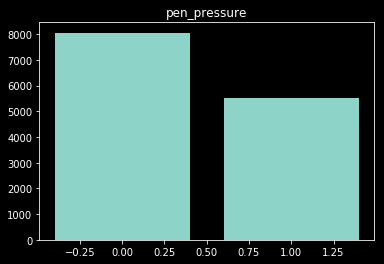

In [89]:
for feature in feature_cols:
    options = df[feature].unique()
    plt.title(feature)
    plt.bar(range(len(options)), df[feature].value_counts())
    plt.show()
    break

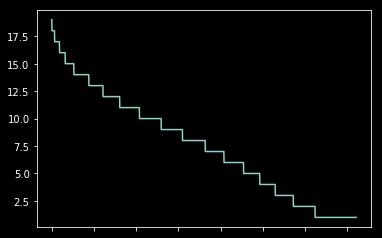

In [85]:
df.writer_id.value_counts().plot()

In [298]:
sample_index = df.writer_id.value_counts()[:10].index
sample = df[df.writer_id.isin(sample_index)].copy()

In [299]:
sample['key'] = 1
sample = pd.merge(sample, sample, on='key')
del sample['key']
sample['h'] = (sample['writer_id_x'] != sample['writer_id_y']).astype(int)

In [300]:
sample.h.sum()/len(sample)

0.8999725283111016

In [301]:
len(sample)

32761

In [302]:
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator, HillClimbSearch, BicScore
from pgmpy.inference import VariableElimination

In [303]:
def get_blank_model(sample):
    node_cols = ['h']
    for feature in feature_cols:
        for f in sample.columns[sample.columns.str.startswith(feature)]:
            node_cols.append(f)
        
    model = BayesianModel()
    model.add_nodes_from(node_cols)
    return model

def tuples_to_edges(tuples):
    edges = []
    for z in ['x', 'y']:
        edges += [
            (f'f{u}_{z}', f'f{v}_{z}') if v > 0 else (f'f{u}_{z}', f'h')
            for (u, v) in tuples
        ]
    return edges

def generate_model(tuples):
    model = get_blank_model()
    edges = tuples_to_edges(tuples)
    model.add_edges_from(edges)
    model.fit(df)
    return model

In [304]:
feature_x_cols = [f + '_x' for f in feature_cols]

In [305]:
sample_x = sample[feature_x_cols].copy()

In [165]:
%%time
est = HillClimbSearch(sample_x, scoring_method=BicScore(sample_x))
model = est.estimate()
print(sorted(model.nodes()))
print(model.edges())

['constancy_x', 'dimension_x', 'entry_stroke_a_x', 'exit_stroke_d_x', 'formation_n_x', 'is_continuous_x', 'is_lowercase_x', 'letter_spacing_x', 'pen_pressure_x', 'size_x', 'slantness_x', 'staff_of_a_x', 'staff_of_d_x', 'tilt_x', 'word_formation_x']
[('pen_pressure_x', 'size_x'), ('pen_pressure_x', 'staff_of_a_x'), ('pen_pressure_x', 'is_continuous_x'), ('pen_pressure_x', 'word_formation_x'), ('pen_pressure_x', 'slantness_x'), ('pen_pressure_x', 'dimension_x'), ('size_x', 'exit_stroke_d_x'), ('size_x', 'letter_spacing_x'), ('dimension_x', 'size_x'), ('dimension_x', 'staff_of_a_x'), ('dimension_x', 'is_continuous_x'), ('dimension_x', 'word_formation_x'), ('dimension_x', 'slantness_x'), ('is_continuous_x', 'constancy_x'), ('slantness_x', 'exit_stroke_d_x'), ('slantness_x', 'letter_spacing_x'), ('slantness_x', 'size_x'), ('slantness_x', 'word_formation_x'), ('slantness_x', 'tilt_x'), ('slantness_x', 'is_continuous_x'), ('staff_of_a_x', 'letter_spacing_x'), ('staff_of_a_x', 'staff_of_d_x'),

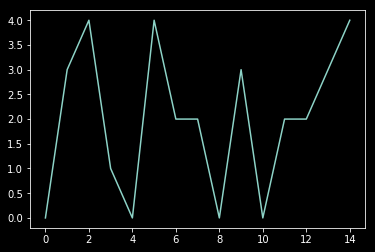

In [179]:
plt.plot(model.in_degree().values())

,pen_pressure,letter_spacing,size,dimension,is_lowercase,is_continuous,slantness,tilt,entry_stroke_a,staff_of_a,formation_n,staff_of_d,exit_stroke_d,word_formation,constancy
0,2,2,2,1,2,2,3,2,1,2,2,3,2,2,1
1,2,2,2,2,2,2,3,1,1,2,2,3,1,2,2
2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2
3,2,2,2,1,2,2,1,1,1,1,1,1,1,1,1
4,2,2,2,2,2,2,2,1,1,2,2,2,2,2,2
5,2,2,1,1,2,2,3,1,1,2,2,2,3,2,2
6,2,1,2,2,2,2,2,1,1,3,2,2,3,2,2
7,2,3,2,2,2,1,2,1,1,1,2,2,2,2,2
8,2,2,2,2,2,1,1,1,1,4,1,2,3,1,2
9,1,1,2,2,2,2,1,1,1,2,2,2,2,2,2


In [306]:
%%time

models = {}
for max_in in range(1,6):
    print(max_in)
    est = HillClimbSearch(sample_x, scoring_method=BicScore(sample_x))
    _model = est.estimate(max_indegree=max_in)
    models[max_in] = _model

1
CPU times: user 32.1 s, sys: 55.9 ms, total: 32.2 s
Wall time: 32.2 s


In [307]:
sample_predict = sample_x.copy()
sample_predict.drop('pen_pressure_x', axis=1, inplace=True)

In [331]:
def split_data(data):
    shuffled_indices = np.random.choice(len(data), size=len(data), replace=False)
    assert len(data) == len(shuffled_indices), f"{len(data)} != {len(shuffled_indices)}"
    train_len = int(len(data)*0.8)
    train_data = data.iloc[shuffled_indices[:train_len]]
    test_data = data.iloc[shuffled_indices[train_len:]]
    return train_data - train_data.min(), test_data - test_data.min()

In [332]:
train_data, test_data = split_data(sample_x)

In [337]:
%%time
models[1].fit(train_data)
sample_predict = test_data.copy()
sample_predict.drop('pen_pressure_x', axis=1, inplace=True)
models[1].predict(sample_predict - 1)

CPU times: user 1min 2s, sys: 285 ms, total: 1min 2s
Wall time: 1min 1s


In [338]:
pred = models[1].predict(sample_predict - 1)

In [339]:
pred

,pen_pressure_x
29972,1
8899,1
22728,1
9994,1
24994,1
21887,1
4149,1
4862,1
24428,0
1246,1


In [346]:
(test_data.pen_pressure_x == pred.pen_pressure_x).sum()/len(pred)

0.39203418281703034